# Integrantes
+ Francisco Beltrami 
+ Gonzalo Madariaga
+ Manuel Rojas


## 1) Preparacion del Training Set

(Import e instalacion de librerias)

In [1]:
import tensorflow as tf
import plotly.graph_objects as go
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import numpy as np
import pandas as pd
import os 
import re

from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer


from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.5.0


In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!pip install pyspellchecker
from spellchecker import SpellChecker

# 1.1) Prepocesamiento de la data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/manuel-rojas-reyes/data/main/Dataset_Twitter.csv')

df.head(10)

,text,label
0,Benefits of Going Green As A Business â€“ Get ...,bot
1,"Sarah: ""have you ever met a good-looking perso...",human
2,Finna doctor all this,bot
3,Check Out this Overview of Major Web Conferenc...,bot
4,this right here is why you guys should have vo...,human
5,Why aren't you the same person you were a few ...,human
6,@FlatironD HI,bot
7,Mommy :) http://t.co/AYejfjWOij,human
8,SOS someone come kidnap me from act prep ASAP,human
9,SISYPHUSÃ¢â‚¬â„¢ LAMENT: My father never buys ...,human


Descripción de la data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10500 non-null  object
 1   label   10500 non-null  object
dtypes: object(2)
memory usage: 164.2+ KB


Contador de valores NaN

In [6]:
df.isna().sum()

text     0
label    0
dtype: int64

In [7]:
# word_count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))

# url_count
df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# stop_word_count
df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# punctuation_count
#df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

# 1.2) Gráficos de la data

> Distribución de los tweets



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'tweets')

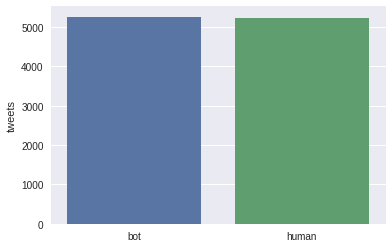

In [8]:
x=df.label.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('tweets')

In [9]:
all_words = df['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Contador de palabras'
    )]

layout = go.Layout(
    title='Top 50 Frecuencias de palabras principales (sin limpiar) en la data'
)

fig = go.Figure(data=data, layout=layout)

fig.show()

In [10]:
words = df["text"].values


## Proceso de limpieza de tweets


In [11]:
!pip install ftfy
import ftfy

Transformación de caracteres especiales

In [12]:
text = df["text"]
test=[]
for row in text:
  test.append(ftfy.fix_text(row))

df["text"] = test


In [13]:
def clean(tweet): 
            
    tweet = tweet.lower()  # lowercase

    tweet = re.sub(r'[!]+', '!', tweet)
    tweet = re.sub(r'[?]+', '?', tweet)
    tweet = re.sub(r'[.]+', '.', tweet)
    tweet = re.sub(r"'", "", tweet)
    tweet = re.sub('\s+', ' ', tweet).strip()  # Remove and double spaces

    # remove some puncts (except . ! # ?)
    tweet = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+#', '', tweet)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub(r'EMOJI', tweet)
  
    

    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    tweet = re.sub(r'&amp;?', 'and', tweet)  # replace & -> and
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r"http?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    #tweet = re.sub(r"https?:\/\/t.co", "", tweet)
    #tweet = re.sub(r"http?:\/\/t.co", "", tweet)
    tweet = re.sub(r'http\S+', "", tweet)
    tweet = re.sub(r'https\S+', "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f'{p}')
        
    # ... and ..
    tweet = tweet.replace('...', '...')
    if '...' not in tweet:
        tweet = tweet.replace('..', '...')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)


    return tweet

In [14]:
df['text'] = df['text'].str.lower()
# removing special characters and numbers
df['text_cleaned'] = df['text'].apply(lambda s : clean(s))

Proceso de tokenización

In [15]:
import spacy
nlp = spacy.load('en')

In [16]:
df = df.copy()

In [17]:
df['parsed'] = df.text_cleaned.apply(nlp)


Primeros 20 tweets limpios y transformados

In [18]:
text = df["parsed"]
i=0
for row in text:
  if i > 20:
    break
  print(row)
  i=i+1



benefits of going green as a business – get certified! 
sarah: "have you ever met a good-looking person who was socially awkward? no, because they dont exist" #bbcan3 
finna doctor all this
check out this overview of major web conferencing services 
this right here is why you guys should have voted pantry in that one vote - so much staff in & out of there all the time
why arent you the same person you were a few weeks ago:/
@flatirond hi
mommy :) 
sos someone come kidnap me from act prep asap
sisyphus lament: my father never buys yaya meals  | @oscarfbtan @inq_opinion #yayameals 
rt @beautifulplcs: nyc where the city meets central park. 
cloud security architect: cloud security architect vita64528951 *chester, va* this position reviews proposed changes & projects associated with cloud and hosting services used by vita and the executive branch…  EMOJI#it #job #hiring #it #techjob #itjob 
i need to make a new mix tape for my car
leadership bro make weed legal at school
@gangstaphil "it i

In [19]:
label = df["label"]
temp=[]
for row in label:
  if row == "human":
    temp.append(1)
  elif row == "bot":
    temp.append(0)
  else:
    temp.append()
df["label"] = temp

In [20]:
df.to_csv("dataframe_cleaned.csv")

Se puede apreciar que la columna texto es tokenizada 

2) **Crear una red neuronal (deep learning methods) y entrenarla para que prediga si el texto
fue hecho por bot o un usuario genuino (humano)(60%)**

In [44]:
dfc = pd.read_csv("dataframe_cleaned.csv")



# Text data tokenization

In [45]:
train_data, test_data = train_test_split(dfc,test_size = 0.2)
print("Train Data size : ",len(train_data))
print("Test Data size : ",len(test_data))

Train Data size :  8400
Test Data size :  2100


In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size : ",vocab_size)

Vocab size :  20947


Text data to fit on Glove Embedding

In [47]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = 30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = 30)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (8400, 30)
Testing X Shape: (2100, 30)


In [48]:
y_train = train_data.label
y_test = test_data.label

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_train,y_test)

y_train shape: (8400,)
y_test shape: (2100,)
3082     0
8454     0
5875     1
10036    1
5056     0
        ..
4292     1
1431     0
6458     0
9144     1
5200     1
Name: label, Length: 8400, dtype: int64 735     0
1259    1
8611    0
4588    1
2255    0
       ..
1612    1
7724    0
6291    1
5179    0
2774    0
Name: label, Length: 2100, dtype: int64


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
GLOVE_EMB = '/content/drive/MyDrive/glove.6B.300d.txt'
# Vector de palabras previamente entrenado
# Este archivo lo sacamos de kaggle y lo subimos a drive ya que pesa un 1GB y github solo admite hasta 25MB
# https://www.kaggle.com/thanakomsn/glove6b300dtxt
# Es necesario cargarlo en su drive o su dispositivo local
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 512

In [51]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [52]:
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [53]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],                                            
                                            input_length=30,
                                           trainable=False)

# Modeling

In [54]:
inputs = Input(shape=(30,),dtype = 'int32')

embedding = embedding_layer(inputs)
net = SpatialDropout1D(0.2)(embedding)
net = Bidirectional(LSTM(64,dropout=0.2, recurrent_dropout=0.2))(net)
net = Dense(1,activation = 'sigmoid')(net)

outputs = net
model = tf.keras.Model(inputs,outputs)

In [55]:
model.compile(optimizer = Adam(learning_rate = LR),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [56]:
callback = ReduceLROnPlateau(factor=0.1,
                    min_lr = 0.01,
                    monitor = 'val_loss',
                    verbose = 1)

In [57]:
history = model.fit(x_train,
                    y_train,
                    batch_size=512,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    callbacks = [callback])

Epoch 1/10
17/17 [==============================] - 21s 940ms/step - loss: 0.6223 - accuracy: 0.6917 - val_loss: 0.5144 - val_accuracy: 0.7857
Epoch 2/10
17/17 [==============================] - 15s 910ms/step - loss: 0.4940 - accuracy: 0.7670 - val_loss: 0.4326 - val_accuracy: 0.8105
Epoch 3/10
17/17 [==============================] - 15s 913ms/step - loss: 0.4358 - accuracy: 0.8031 - val_loss: 0.3925 - val_accuracy: 0.8333
Epoch 4/10
17/17 [==============================] - 16s 913ms/step - loss: 0.3955 - accuracy: 0.8262 - val_loss: 0.3535 - val_accuracy: 0.8524
Epoch 5/10
17/17 [==============================] - 16s 913ms/step - loss: 0.3719 - accuracy: 0.8404 - val_loss: 0.3271 - val_accuracy: 0.8652
Epoch 6/10
17/17 [==============================] - 16s 916ms/step - loss: 0.3470 - accuracy: 0.8555 - val_loss: 0.3654 - val_accuracy: 0.8295
Epoch 7/10
17/17 [==============================] - 16s 918ms/step - loss: 0.3278 - accuracy: 0.8618 - val_loss: 0.3244 - val_accuracy: 0.8633

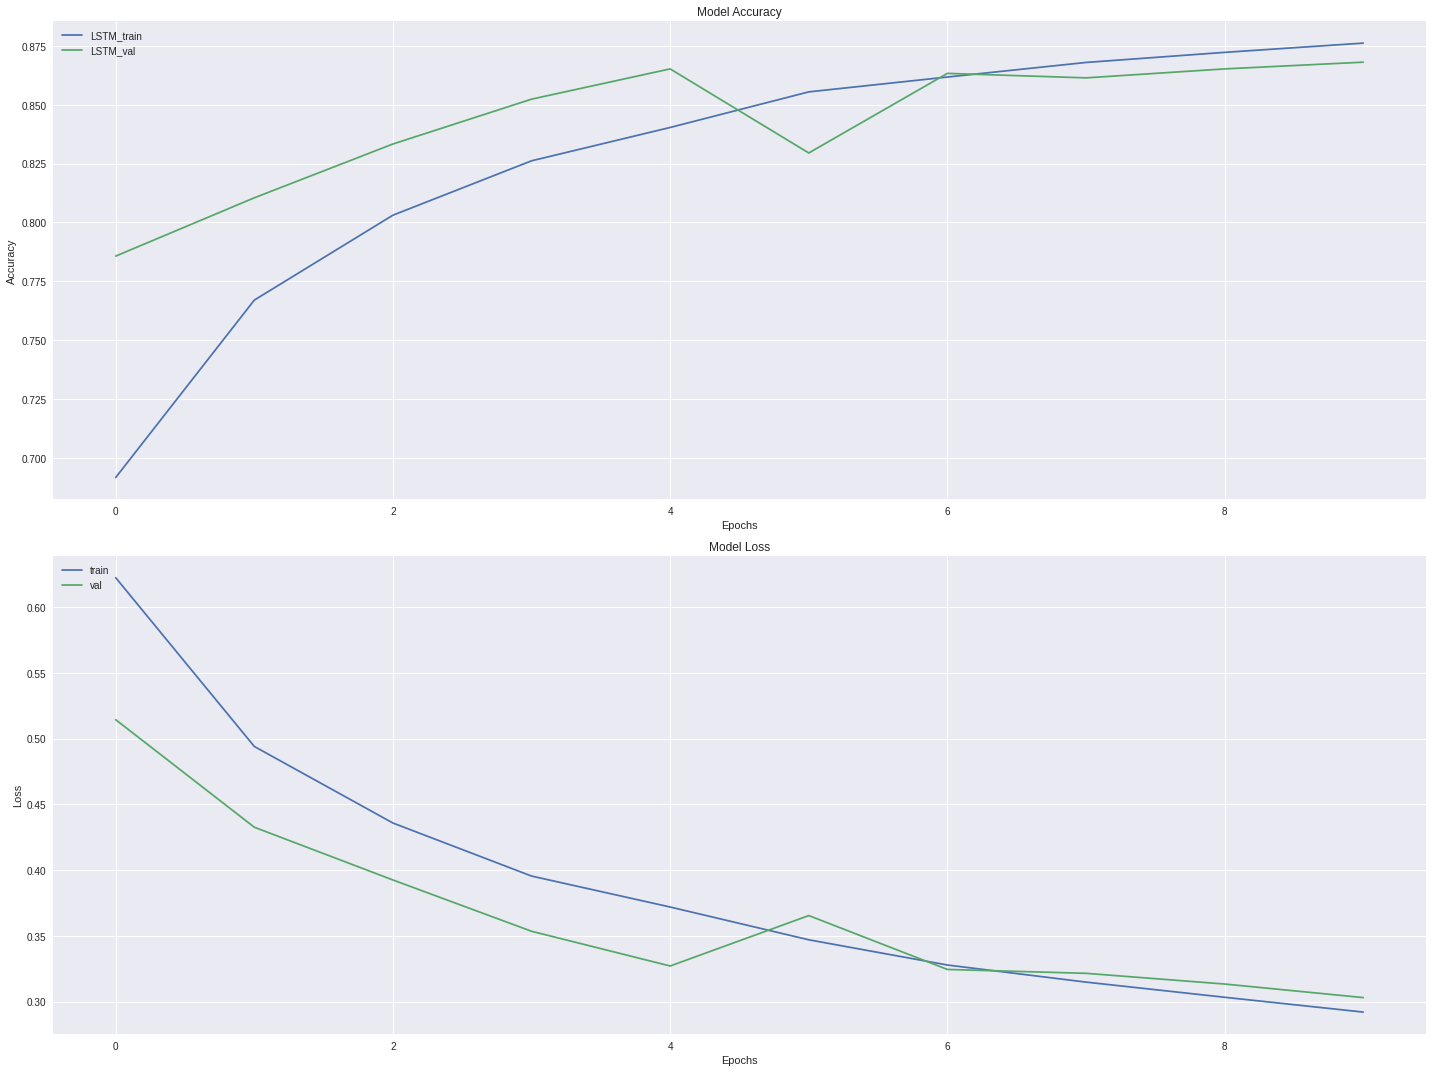

In [58]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()